# Cosmic shear with Einstein ring simulations

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import pickle
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## import M31 image and decompose it

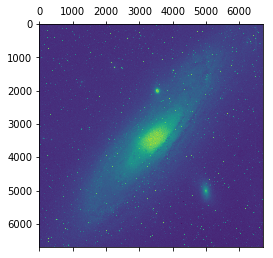

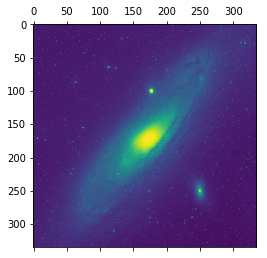

the number of shapelet coefficients is:  231


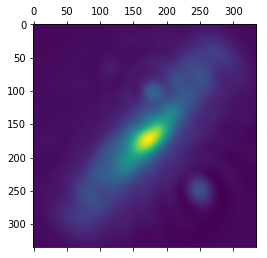

In [2]:
# this makes use of the shapelet decomposition (Refregier 2003) used for lensing in Birrer et al. 2015

# import of the python package astrofunc
import astropy.io.fits as pyfits
from astrofunc.LightProfiles.shapelets import ShapeletSet, Decompose
import astrofunc.util as util

# import M31 image, credit: https://www.spacetelescope.org/projects/fits_liberator/m31data/
hdu = pyfits.open('f001a1hr.fits')
m31_data = hdu[0].data
hdu.close()

# cut out the boundries and plot the image
m31_data_cut = m31_data[100:6800,100:6800]
plt.matshow(m31_data_cut)
plt.show()

# degrate pixel resolution
factor = 20  # degrading factor
numPix_large = len(m31_data_cut)/factor
x, y = util.make_grid(numPix=numPix_large, deltapix=1)
m31_data_resized = util.re_size(m31_data_cut, factor)
m31_data_resized -= np.median(m31_data_resized[0:10,0:10])
plt.matshow(m31_data_resized)
plt.show()


shapeletSet = ShapeletSet()
decompose = Decompose()
image_1d = util.image2array(m31_data_resized)

# choice of shapelet decompositon
n_max = 20  # 150  # maximum hermitian polynome used (supported to n_max=150)
beta = 30  # 15  # the shapelet scale \beta used (in units of pixels)

# decompose image into shapelet coefficients
param_list = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0)
print "the number of shapelet coefficients is: ", len(param_list)

# reconstruct the image with the decomposed shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, param_list, n_max, beta, center_x=0, center_y=0)
image_reconstructed_2d = util.array2image(image_reconstructed)

plt.matshow(image_reconstructed_2d)
plt.show()

## simulation choices

In [3]:
# import main simulation class of lenstronomy
from lenstronomy.Extensions.SimulationAPI.simulations import Simulation
SimAPI = Simulation()

# data specifics
sigma_bkg = .005  #  background noise per pixel
exp_time = 200.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF
psf_type = 'gaussian'  # 'gaussian', 'pixel', 'NONE'

# lensing quantities
kwargs_shear = {'e1': 0.0, 'e2': -0.1}  # shear values to the source plane
kwargs_foreground = {'gamma1_foreground': 0.0, 'gamma2_foreground':-0.06}  # non-linear shear values to the lens plane
kwargs_spemd = {'theta_E': .66, 'gamma': 2., 'center_x': 0.05, 'center_y': 0, 'q': .9, 'phi_G': 0.}  # parameters of the deflector lens model

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS

beta_model = 0.03  # choice of source size in the input simulation (units of arc seconds)
shapelet_beta = 0.03  # choice of initial shapelet scale in the reconstruction in the lens modelling
n_max_sim = 30  # choice of polynomial order in the shapelet reconstruction in the lens modelling

# Shapelet parameter in the initial simulation
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': param_list/1000., 'center_x': 0.02, 'center_y': 0}

# Sersic parameters in the initial simulation
kwargs_sersic = {'I0_sersic': 40, 'R_sersic': 0.015, 'n_sersic': 1, 'q': .8, 'phi_G': 0.5, 'center_x': 0., 'center_y': 0}
if source_type == 'SERSIC':
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_source_list = [kwargs_sersic]
elif source_type == 'SHAPELETS':
    source_model_list = ['SHAPELETS']
    kwargs_source_list = [kwargs_shapelet]
else:
    raise ValueError("Not valid source_type variable!")

# for this example, we ignore the presence of deflector light
lens_light_model_list = ['NONE']
kwargs_lens_light_list = [{}]


In [4]:
# initial input simulation

# generate the coordinate grid and image properties
kwargs_data_single = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
# generate the psf variables
kwargs_psf_single = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=11, deltaPix=deltaPix, truncate=3, kernel=None)

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEMD', 'EXTERNAL_SHEAR']
kwargs_lens_list = [kwargs_spemd, kwargs_shear]

kwargs_options = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 'foreground_shear': True,  # we explicitly model the non-linear shear components
                  'subgrid_res': 1,  # numerical precision in the ray-tracing. Possibility of sub-pixel precision exists
                 }

# generate image
image_real_lensed_shear = SimAPI.im_sim(kwargs_options, kwargs_data_single, kwargs_psf_single, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_foreground)
# turn 2d data in a 1d data vector
kwargs_data_single['image_data'] = util.image2array(image_real_lensed_shear)

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log10


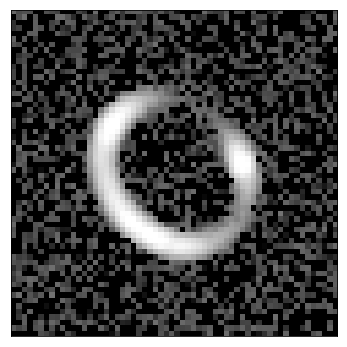

In [5]:
# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real_lensed_shear), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [6]:
# lens models
lens_model_list = []
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []


fixed_lens.append({'gamma': 2.})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E_sigma': .0001, 'ellipse_sigma':0.005, 'gamma_sigma': 0.1
                    , 'center_x_sigma': 0.0001, 'center_y_sigma': 0.0001})


fixed_lens.append({})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'shear_sigma': 0.003})


# lens light models
fixed_lens_light = [{}]
kwargs_lens_light_init = [{}]
kwargs_lens_light_sigma = [{}]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []

for i, model in enumerate(source_model_list):
    if model == 'SHAPELETS':
        fixed_source.append({'n_max': n_max_sim})
        kwargs_source_init.append({'center_x': 0, 'center_y': 0, 'beta': shapelet_beta, 'n_max': n_max_sim})
        kwargs_source_sigma.append({'center_x_sigma': 0.0001, 'center_y_sigma': 0.0001, 'beta_sigma': shapelet_beta/10., 'n_max_sigma': 2})
    if model == 'SERSIC_ELLIPSE':
        fixed_source.append({})
        kwargs_source_init.append(kwargs_sersic)
        kwargs_source_sigma.append({'n_sersic_sigma': 0.001, 'R_sersic_sigma': 0.001, 'ellipse_sigma': 0.001, 'center_x_sigma': 0.0001, 'center_y_sigma': 0.0001})

fixed_else = {}
kwargs_else_init = kwargs_foreground
kwargs_else_sigma = {'shear_foreground_sigma': 0.001}

kwargs_fixed = [fixed_lens, fixed_source, fixed_lens_light, fixed_else]
kwargs_init = [kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_else_init]
kwargs_sigma = [kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_else_sigma]




In [7]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.
job_name = 'test'
input_temp = job_name +'.txt'
output_temp = job_name +'_out.txt'
dir_path = os.getcwd()
path2input_temp = os.path.join(dir_path, input_temp)

fitting_kwargs_list = [{'fitting_routine': 'MCMC', 'n_burn': 1000, 'n_run': 1000, 'walkerRatio': 20, 'mpi': mpi, 'sigma_scale': .1}]

f = open(path2input_temp,'wb')

kwargs_data = [kwargs_data_single]
kwargs_psf = [kwargs_psf_single]

init_samples = None
pickle.dump([kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed, fitting_kwargs_list, init_samples], f)
f.close()

start_time = time.time()
fitting_seq = FittingSequence(kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed)
lens_result, source_result, lens_light_result, else_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_psf_out = fitting_seq.kwargs_psf
output_ = [lens_result, source_result, lens_light_result, else_result, kwargs_psf_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc]
input_ = [kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed, fitting_kwargs_list, init_samples]
path2dump = job_name + '_out.txt'
f = open(path2dump, 'wb')
pickle.dump([input_, output_], f)
f.close()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('Result saved in: %s' % path2dump)
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the MCMC...
('Number of walkers = ', 300)
('Burn-in iterations: ', 1000)
('Sampling iterations:', 1000)
InMemoryStorageUtil does not support storeRandomState
(1534.9836041927338, 'time taken for MCMC sampling')
(1593.5040500164032, 'total time needed for computation')
Result saved in: test_out.txt
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


## analyse MCMC chain

Input parameters in the lens model:
[{'theta_E': 0.66, 'q': 0.9, 'center_x': 0.05, 'center_y': 0, 'phi_G': 0.0, 'gamma': 2.0}, {'e1': 0.0, 'e2': -0.1}]
('reduced chi2 = ', 0.82634266231102738)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Extensions/Plots/output_plots.py:334: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(util.array2image(np.log10(image_raw)), origin='lower',
/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Extensions/Plots/output_plots.py:351: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(makeImage.Data.array2image(model_pure)), origin='lower', vmin=v_min, vmax=v_max,
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


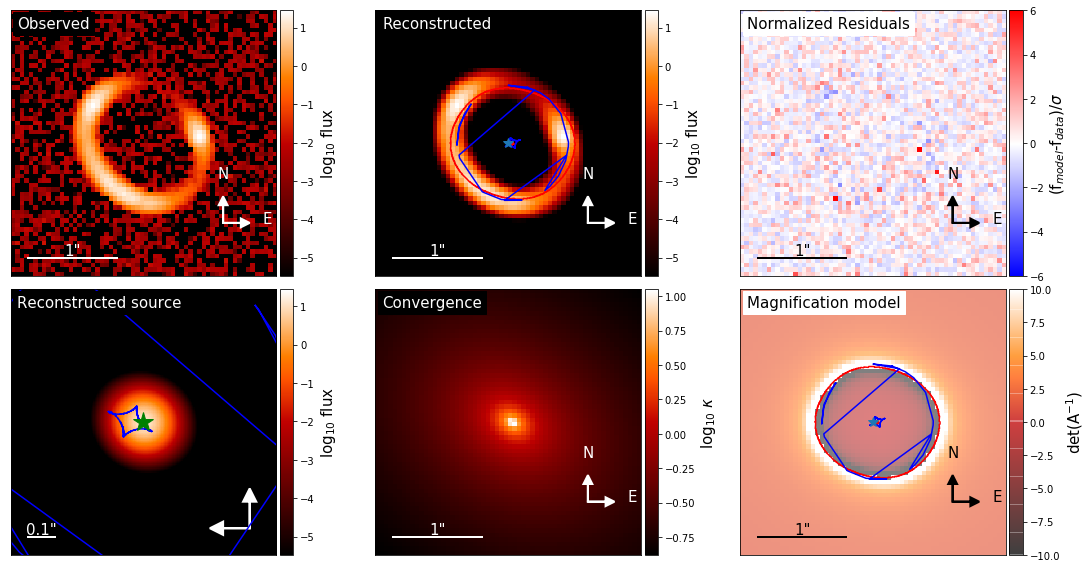

In [8]:
import lenstronomy.Extensions.Plots.output_plots as out_plot
# pre-computed MCMC chains:
# job_name_out = 'test': an elliptical Sersic source light profile
# job_name_out = 'shear_test': a shapelet source model based on M31

job_name_out = 'test'
input_temp = job_name_out +'.txt'
output_temp = job_name_out +'_out.txt'

f = open(output_temp)
[input_, output_] = pickle.load(f)
f.close()
kwargs_data, kwargs_psf, kwargs_options, kwargs_init, kwargs_sigma, kwargs_fixed, fitting_kwargs_list, init_samples = input_
lens_result, source_result, lens_light_result, else_result, kwargs_psf, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = output_

print "Input parameters in the lens model:"
print kwargs_init[0]

band_i = 0
f, axes = out_plot.plot_reconstruction(kwargs_data[band_i], kwargs_psf[band_i], kwargs_options, lens_result, source_result, lens_light_result,
                            else_result, cmap_string="gist_heat", source_sigma=0.03)
f.show()


number of non-linear parameters in the MCMC process:  15
parameters in order:  ['theta_E', 'e1_lens', 'e2_lens', 'center_x_lens', 'center_y_lens', 'e1', 'e2', 'center_x_source_light', 'center_y_source_light', 'n_sersic_source_light', 'R_sersic_source_light', 'e1_source_light', 'e2_source_light', 'shear_foreground_1', 'shear_foreground_2']
number of evaluations in the MCMC process:  300000


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


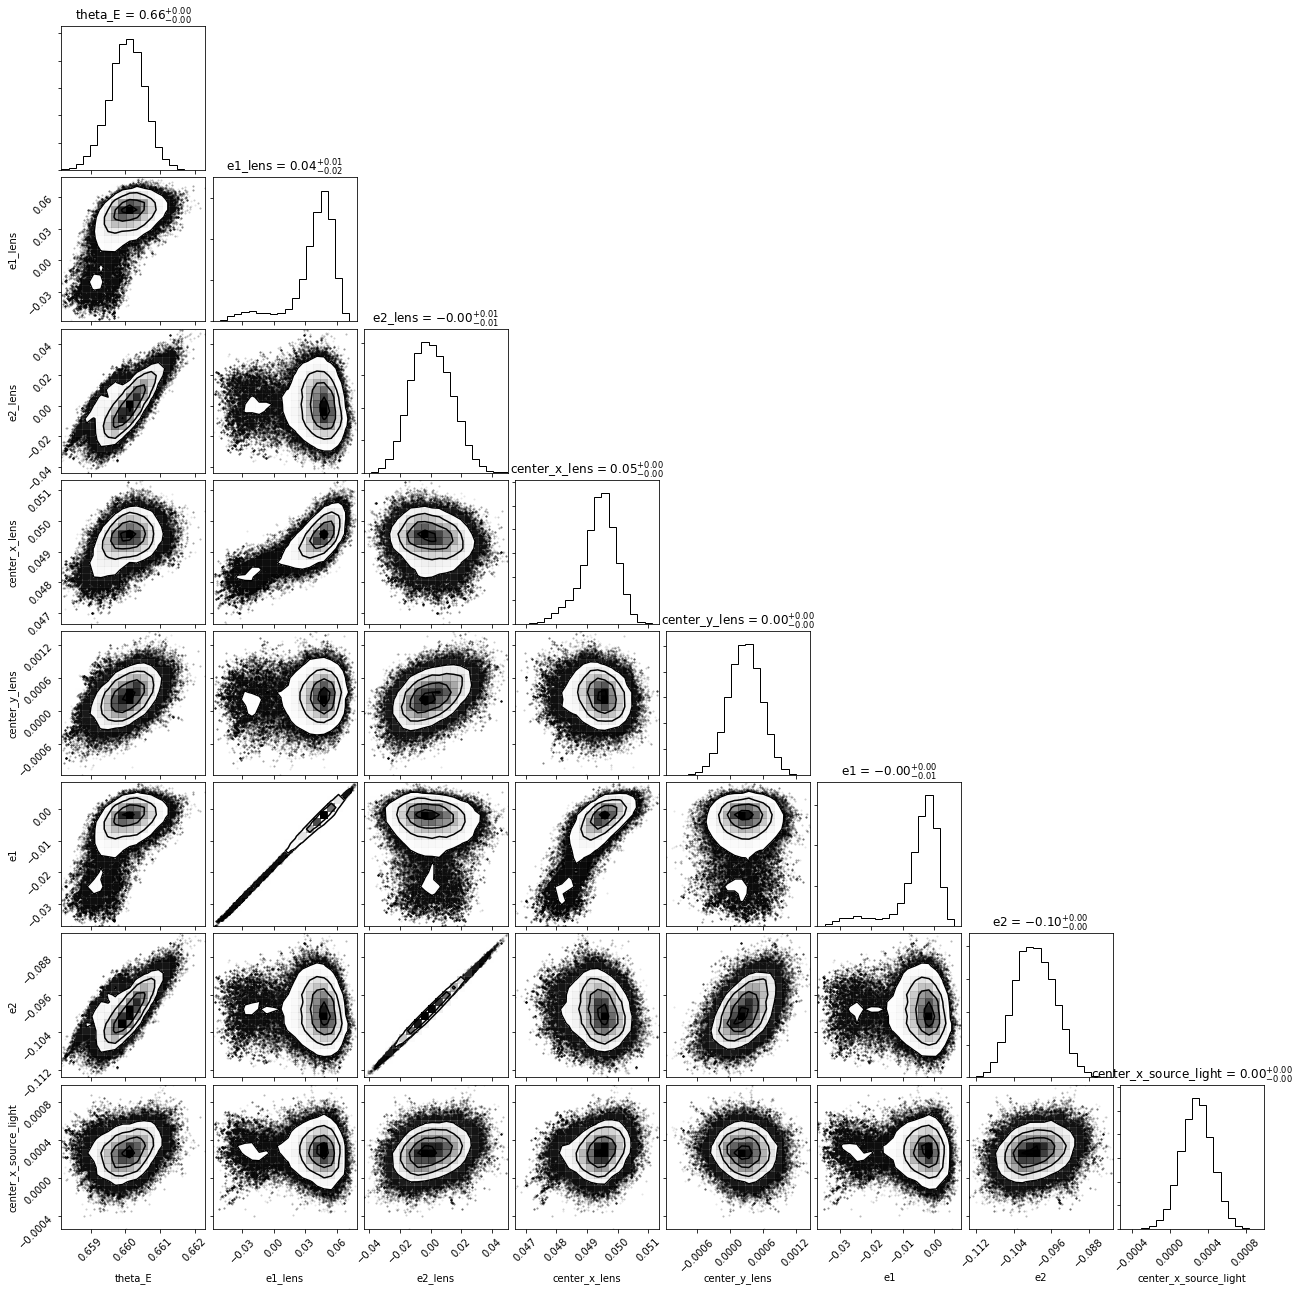

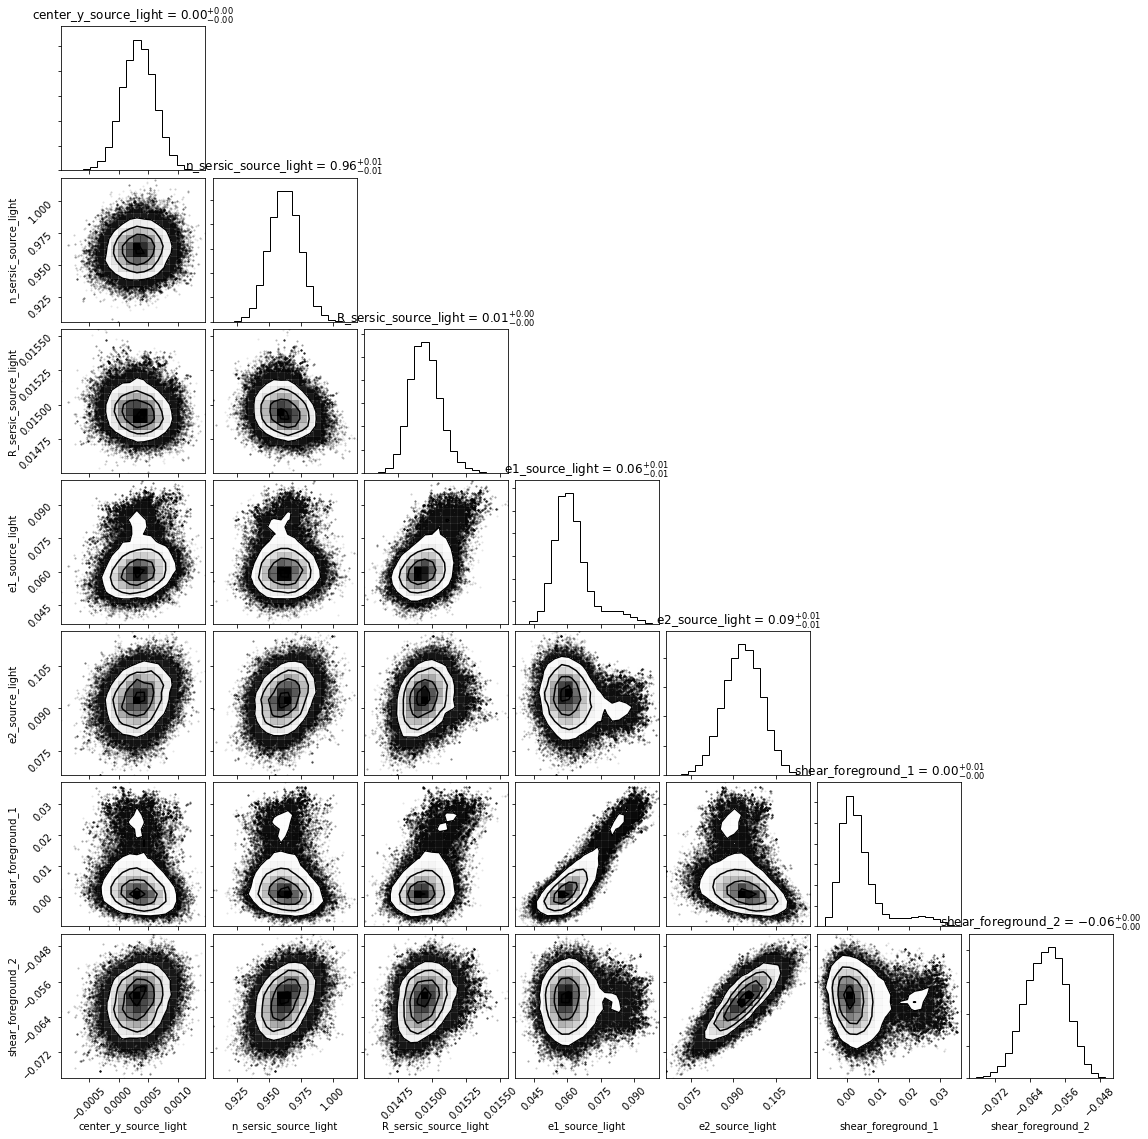

In [9]:
# the results of the MCMC chain, split in two corner plots

print "number of non-linear parameters in the MCMC process: ", len(param_mcmc)
print "parameters in order: ", param_mcmc
print "number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0]
if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
        plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)